# BOLD rs-fMRI: confounds classifier

Are confounding variables, such as motion and global signals, capable of classifying AVGP from NVGP?

Below, we use a list of confounds extracted using fmriprep during preprocessing to predict subject group. Se expect to see a no significant difference from chance level as measured by prediction accuracy.

## Setup

In [134]:
import pandas as pd
from nilearn.interfaces.bids import get_bids_files
from tqdm import tqdm
import numpy as np

## Prepare Data

In [164]:
confound_files = get_bids_files(
    'data/julia2018/derivatives/fmriprep_2020',
    # file_tag='timeseries',
    modality_folder='func',
    filters=[('ses', 'rest'), ('desc', 'confounds')],
    file_type='tsv')

_confounds_lst = []

for confound_file in confound_files:
    df = pd.read_csv(confound_file, sep='\t')
    # calculate mean confounds averaged over all the scans
    df = df.mean(axis=0).to_frame().T
    df['subject'] = confound_file.split('/')[4].replace('sub-','')
    df['group'] = df['subject'].apply(lambda x: x[:4])
    _confounds_lst.append(df)

confounds = pd.concat(_confounds_lst).reset_index(drop=True)

subjects = confounds.pop('subject')
groups = confounds.pop('group')

y = groups
X = confounds.dropna(axis=1)

## Pipeline and hyper-parameter tuning

In [165]:
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('zv', VarianceThreshold(0.0)),
    ('scale', StandardScaler()),
    ('select', SelectFromModel(SVC(kernel='linear'))),
    ('clf', SVC(kernel='linear', probability=True))
])

param_grid = {
    
}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=3, scoring='accuracy', n_jobs=-1)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20)

## Cross-validated model fitting

In [166]:
# hyper-parameter optimization
grid.fit(X, y)
model = grid.best_estimator_

# cross-validated model fitting
scores = []
for train, test in tqdm(cv.split(X, y), total=cv.get_n_splits()):
    model.fit(X.iloc[train], y.iloc[train])
    score = model.score(X.iloc[test], y.iloc[test])
    scores.append(score)

print(f'score (mean/std): {np.mean(scores):.3f}/{np.std(scores):.3f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.429 total time=   0.0s
[CV 5/5] END ..................................., score=0.167 total time=   0.0s
[CV 2/5] END ..................................., score=0.429 total time=   0.0s[CV 4/5] END ..................................., score=0.667 total time=   0.0s
[CV 3/5] END ..................................., score=0.500 total time=   0.0s



100%|██████████| 100/100 [00:00<00:00, 140.32it/s]

score (mean/std): 0.480/0.185


## Chance level

In [167]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

chance_model = DummyClassifier(strategy='most_frequent')

for train, test in tqdm(cv.split(X, y), total=cv.get_n_splits()):
    chance_model.fit(X.iloc[train], y.iloc[train])
    y_pred = chance_model.predict(X.iloc[test])
    score = accuracy_score(y.iloc[test], y_pred)
    scores.append(score)

print(f'chance score (mean/std): {np.mean(scores):.3f}/{np.std(scores):.3f}')

100%|██████████| 100/100 [00:00<00:00, 894.94it/s]

chance score (mean/std): 0.476/0.133


## Feature importance

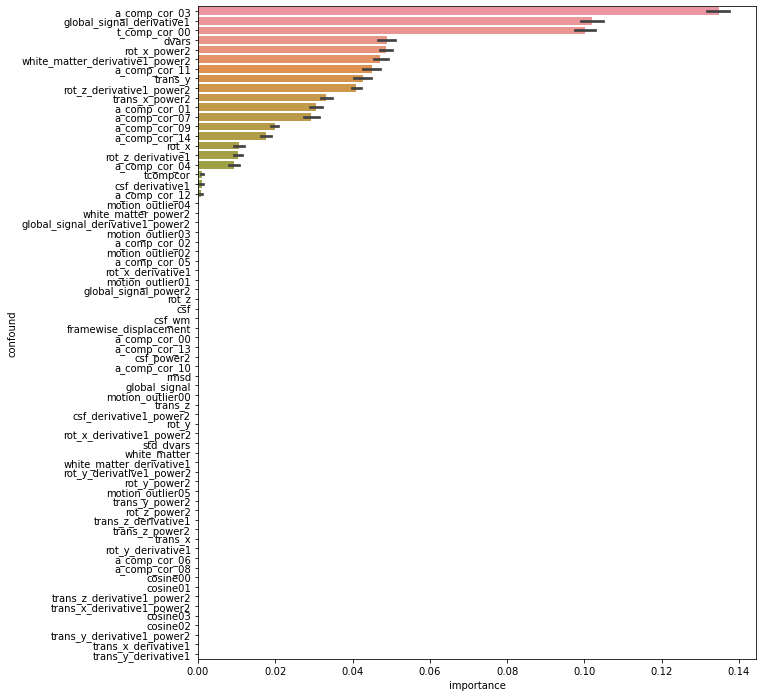

In [188]:
from sklearn.inspection import permutation_importance

perm_results = permutation_importance(model,
                                      X, y,
                                      n_repeats=1000,
                                      scoring='accuracy',
                                      n_jobs=-1)

perm_importances = pd.DataFrame(perm_results.importances, index=X.columns)

perm_importances = perm_importances.reset_index().rename(columns={'index':'confound'})
perm_importances = perm_importances.melt(
    id_vars=['confound'],
    var_name='cv_repetition',
    value_name='importance')

perm_importances['mean_importance'] = perm_importances.groupby('confound')['importance'].transform('mean')
perm_importances = perm_importances.sort_values(by='mean_importance', ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 1, figsize=(10,12))
sns.barplot(data=perm_importances, x='importance', y='confound', orient='h', ax=ax)
plt.show()
